# L3 Selection - DICOM files

In [1]:
"""
  Module:  dicom_to_nifti.py
  Nov 28, 2019
  David Gobbi
"""

import pydicom
import nibabel as nib
import numpy as np
import sys
import os


def create_affine(ipp, iop, ps):
    """Generate a NIFTI affine matrix from DICOM IPP and IOP attributes.
    The ipp (ImagePositionPatient) parameter should an Nx3 array, and
    the iop (ImageOrientationPatient) parameter should be Nx6, where
    N is the number of DICOM slices in the series.
    The return values are the NIFTI affine matrix and the NIFTI pixdim.
    Note the the output will use DICOM anatomical coordinates:
    x increases towards the left, y increases towards the back.
    """
    # solve Ax = b where x is slope, intecept
    n = ipp.shape[0]
    A = np.column_stack([np.arange(n), np.ones(n)])
    x, r, rank, s = np.linalg.lstsq(A, ipp, rcond=None)
    # round small values to zero
    x[(np.abs(x) < 1e-6)] = 0.0
    vec = x[0,:] # slope
    pos = x[1,:] # intercept

    # pixel spacing should be the same for all image
    spacing = np.ones(3)
    spacing[0:2] = ps[0,:]
    if np.sum(np.abs(ps - spacing[0:2])) > spacing[0]*1e-6:
        sys.stderr.write("Pixel spacing is inconsistent!\n");

    # compute slice spacing
    spacing[2] = np.round(np.sqrt(np.sum(np.square(vec))), 7)

    # get the orientation
    iop_average = np.mean(iop, axis=0)
    u = iop_average[0:3]
    u /= np.sqrt(np.sum(np.square(u)))
    v = iop_average[3:6]
    v /= np.sqrt(np.sum(np.square(v)))

    # round small values to zero
    u[(np.abs(u) < 1e-6)] = 0.0
    v[(np.abs(v) < 1e-6)] = 0.0

    # create the matrix
    mat = np.eye(4)
    mat[0:3,0] = u*spacing[0]
    mat[0:3,1] = v*spacing[1]
    mat[0:3,2] = vec
    mat[0:3,3] = pos

    # check whether slice vec is orthogonal to iop vectors
    dv = np.dot(vec, np.cross(u, v))
    qfac = np.sign(dv)
    if np.abs(qfac*dv - spacing[2]) > 1e-6:
        sys.stderr.write("Non-orthogonal volume!\n");

    # compute the nifti pixdim array
    pixdim = np.hstack([np.array(qfac), spacing])

    return mat, pixdim


def convert_coords(vol, mat):
    """Convert a volume from DICOM coords to NIFTI coords or vice-versa.
    For DICOM, x increases to the left and y increases to the back.
    For NIFTI, x increases to the right and y increases to the front.
    The conversion is done in-place (volume and matrix are modified).
    """
    # the x direction and y direction are flipped
    convmat = np.eye(4)
    convmat[0,0] = -1.0
    convmat[1,1] = -1.0

    # apply the coordinate change to the matrix
    mat[:] = np.dot(convmat, mat)

    # look for x and y elements with greatest magnitude
    xabs = np.abs(mat[:,0])
    yabs = np.abs(mat[:,1])
    xmaxi = np.argmax(xabs)
    yabs[xmaxi] = 0.0
    ymaxi = np.argmax(yabs)

    # re-order the data to ensure these elements aren't negative
    # (this may impact the way that the image is displayed, if the
    # software that displays the image ignores the matrix).
    if mat[xmaxi,0] < 0.0:
        # flip x
        vol[:] = np.flip(vol, 2)
        mat[:,3] += mat[:,0]*(vol.shape[2] - 1)
        mat[:,0] = -mat[:,0]
    if mat[ymaxi,1] < 0.0:
        # flip y
        vol[:] = np.flip(vol, 1)
        mat[:,3] += mat[:,1]*(vol.shape[1] - 1)
        mat[:,1] = -mat[:,1]

    # eliminate "-0.0" (negative zero) in the matrix
    mat[mat == 0.0] = 0.0


def load_dicom_series(folder):
    """Load a series of dicom files and return a list of datasets.
    The resulting list will be sorted by InstanceNumber.
    """

    files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    # create list of tuples (InstanceNumber, DataSet)
    dataset_list = []
    for f in files:
        ds = pydicom.dcmread(f)
        try:
            i = int(ds.InstanceNumber)
        except (AttributeError, ValueError):
            i = -1
        dataset_list.append( (i, ds) )

    # sort by InstanceNumber (the first element of each tuple)
    dataset_list.sort(key=lambda t: t[0])

    # get the dataset from each tuple
    series = [t[1] for t in dataset_list]

    patient_name = series[0].get("PatientName", "NA")

    return series, patient_name


def dicom_to_volume(dicom_series):
    """Convert a DICOM series into a float32 volume with orientation.
    The input should be a list of 'dataset' objects from pydicom.
    The output is a tuple (voxel_array, voxel_spacing, affine_matrix)
    """
    # Create numpy arrays for volume, pixel spacing (ps),
    # slice position (ipp or ImagePositinPatient), and
    # slice orientation (iop or ImageOrientationPatient)
    n = len(dicom_series)
    shape = (n,) + dicom_series[0].pixel_array.shape
    vol = np.empty(shape, dtype=np.float32)
    ps = np.empty((n,2), dtype=np.float64)
    ipp = np.empty((n,3), dtype=np.float64)
    iop = np.empty((n,6), dtype=np.float64)

    for i, ds in enumerate(dicom_series):
        # create a single complex-valued image from real,imag
        image = ds.pixel_array
        try:
            slope = float(ds.RescaleSlope)
        except (AttributeError, ValueError):
            slope = 1.0
        try:
            intercept = float(ds.RescaleIntercept)
        except (AttributeError, ValueError):
            intercept = 0.0
        vol[i,:,:] = image*slope + intercept
        ps[i,:] = dicom_series[i].PixelSpacing
        ipp[i,:] = dicom_series[i].ImagePositionPatient
        iop[i,:] = dicom_series[i].ImageOrientationPatient

    # create nibabel-style affine matrix and pixdim
    # (these give DICOM LPS coords, not NIFTI RAS coords)
    affine, pixdim = create_affine(ipp, iop, ps)
    return vol, pixdim, affine


def dicom_to_nifti(folder):

    # load the files to create a list of slices
    series, patient_name = load_dicom_series(folder)
    if not series:
        sys.stderr.write("Unable to read DICOM files.\n")
        return 1

    # reconstruct the images into a volume
    vol, pixdim, mat = dicom_to_volume(series)

    # convert DICOM coords to NIFTI coords (in-place)
    convert_coords(vol, mat)

    return nib.Nifti1Image(vol.T, mat), patient_name


In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import os
import verse.utils.data_utilities as dutils

In [16]:
directory = '/home/pedrofrancescon/Desktop/TCC_local/images/CIMAD/volume_tx_abdomen_s_c'

img = "4899"

# img = "19811"
# img = "73264"
# img = "76172"

img_nib, patient_name = dicom_to_nifti(os.path.join(directory, img))
print(patient_name)
img_nib.shape

DIRCE FRACARO


(512, 512, 487)

In [17]:
directory = '/home/pedrofrancescon/Desktop/TCC_local/results/payer_l3'

ctd_list = dutils.load_centroids(os.path.join(directory,f'{img}/{img}_ctd.json'))
ctd_list

[('L', 'A', 'S'),
 [8, 257.33117935505317, 256.34873670212767, 466.90322265625],
 [9, 255.1228390957447, 236.0983626994681, 457.13720703125],
 [10, 254.16362616356383, 215.37319232047872, 446.70908203125],
 [11, 253.12603889627658, 195.57442652925533, 434.04228515625],
 [12, 253.30755485372342, 180.10692320478722, 419.49150390625],
 [13, 254.70493267952128, 168.90334109042556, 401.5013671875],
 [14, 257.7236951462766, 162.90525265957444, 382.965478515625],
 [15, 259.7880236037234, 159.64012632978722, 363.7728759765625],
 [16, 259.9194647606383, 160.3759142287234, 343.836865234375],
 [17, 260.10060671542556, 163.96498919547872, 324.6632568359375],
 [18, 260.521796043883, 171.9042345412234, 303.8410888671875],
 [19, 261.51982214095744, 182.1572265625, 280.869140625],
 [20, 260.99696642287233, 190.479180518617, 256.092333984375],
 [21, 258.9676072140957, 200.23971492686172, 231.367529296875],
 [22, 256.91655585106383, 204.64891539228722, 205.755322265625],
 [23, 255.3041057180851, 205.233

[*] Image resampled to voxel size: (1, 1, 1)
[*] Rescaled centroid coordinates to spacing (x, y, z) = (1, 1, 1) mm


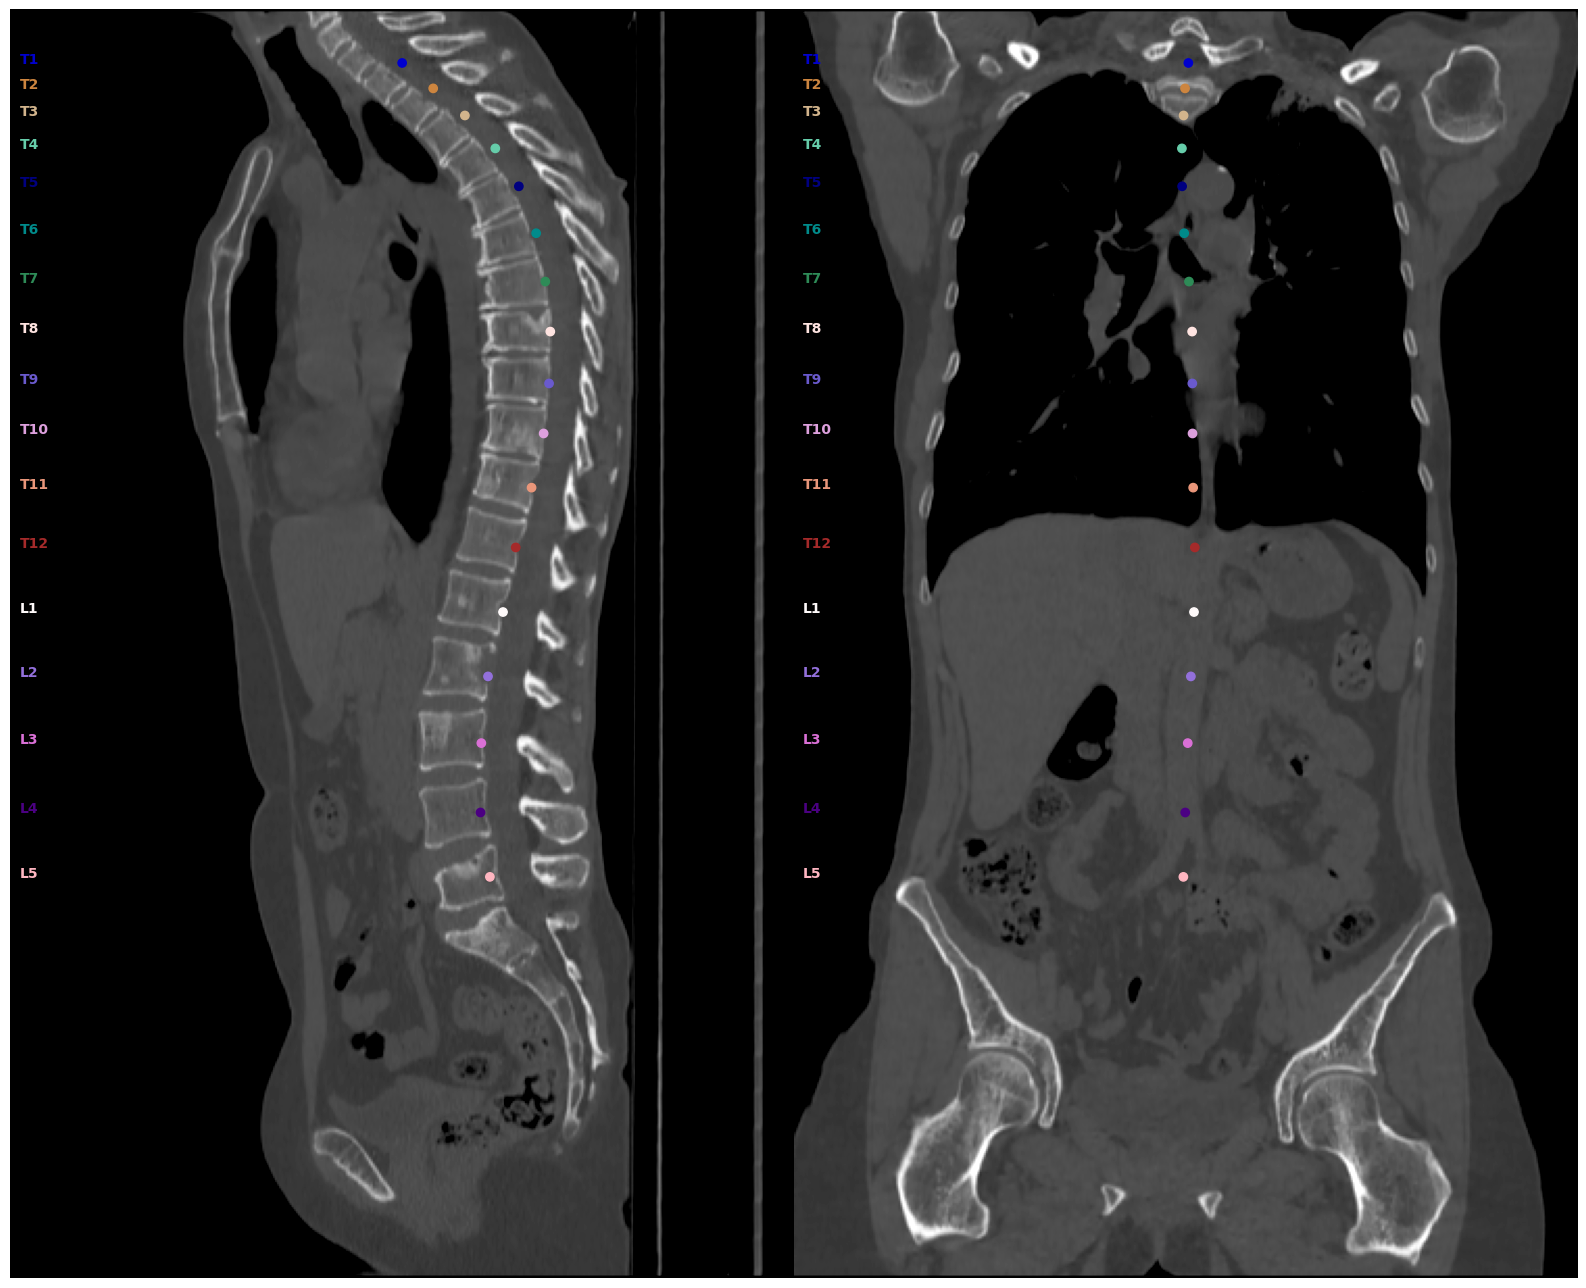

In [18]:
img_iso = dutils.resample_nib(img_nib, voxel_spacing=(1, 1, 1), order=3)
ctd_iso = dutils.rescale_centroids(ctd_list, img_nib, (1,1,1))

img_iso = dutils.reorient_to(img_iso, axcodes_to=('I', 'P', 'L'))
ctd_iso = dutils.reorient_centroids_to(ctd_iso, img_iso)

#check img zooms 
zooms = img_iso.header.get_zooms()

im_np  = img_iso.get_fdata()

im_np_sag = im_np[:,:,int(im_np.shape[2]/2)]
im_np_cor = im_np[:,int(im_np.shape[1]/2),:]

fig, axs = dutils.create_figure(96,im_np_sag, im_np_cor)
axs[0].imshow(im_np_sag, cmap=plt.cm.gray, norm=dutils.wdw_sbone)
dutils.plot_sag_centroids(axs[0], ctd_iso, zooms)

axs[1].imshow(im_np_cor, cmap=plt.cm.gray, norm=dutils.wdw_sbone)
dutils.plot_cor_centroids(axs[1], ctd_iso, zooms)

In [6]:
coords = [vtb_coord[1:] for vtb_coord in ctd_iso if vtb_coord[0] == 22][0]
l3 = im_np[int(coords[0]) + 1,:,:]

dpi = 96
fig_h = round(2 * l3.shape[0] / dpi, 2)
fig_w = round(2 * l3.shape[1] / dpi, 2)
fig, axs = plt.subplots(1, 1, figsize=(fig_w, fig_h))

axs.axis('off')
axs.set_position([1, 0, 1, 1])
axs.imshow(l3, cmap=plt.cm.gray, norm=dutils.wdw_sbone)

# cmap = plt.cm.gray
# dutils.wdw_sbone
# image = cmap(dutils.wdw_sbone(l3))

# save the image
# plt.imsave(f'/home/pedrofrancescon/Desktop/TCC_local/results/{img}.png', image)

IndexError: list index out of range